In [50]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

from google.colab import drive

drive.mount('/content/drive/')

path = '/content/drive/MyDrive/game_state_frame_data.parquet'


Data = pq.read_table(path)
data = Data.to_pandas()
data

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
0,1,2511,T,Team1,100,100,True,-1310,-3333,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
1,1,2527,T,Team1,100,100,True,-1303,-3322,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
2,1,2543,T,Team1,100,100,True,-1290,-3303,292,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
3,1,2559,T,Team1,100,100,True,-1275,-3280,290,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
4,1,2575,T,Team1,100,100,True,-1254,-3262,288,...,900,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221325,30,514156,T,Team2,0,0,False,-1508,-372,200,...,4250,Water,41,01:14,1,4,False,de_overpass,0.0,Player9
221326,30,514172,T,Team2,0,0,False,-1508,-372,200,...,4250,Water,41,01:14,1,4,False,de_overpass,0.0,Player9
221327,30,514188,T,Team2,0,0,False,-1508,-372,200,...,4250,Water,42,01:14,1,4,False,de_overpass,0.0,Player9
221328,30,514204,T,Team2,0,0,False,-1508,-372,200,...,4250,Water,42,01:14,1,4,False,de_overpass,0.0,Player9


In [51]:
grouped_data = data.groupby('round_num')

In [52]:
from shapely.geometry import Point, Polygon

boundary_limits = [(-1735, 250), (-2024, 398), (-2806, 742), (-2472, 1233), (-1565, 580)]

def check_if_coordinate_is_inside_boundary(data_frame,boundary_limits):

  # Define the coordinates of the quadrilateral vertices
  
  # quadrilateral_coords = [(1, 1), (4, 2), (3, 5), (1.5, 4)]

  # Create a Polygon object from the quadrilateral coordinates
  quadrilateral = Polygon(boundary_limits)


  for index, row in data_frame.iterrows():

  # Define the coordinates of the point to check
    point_coords = (row['x'],row['y'])

  # Create a Point object from the point coordinates
    point = Point(point_coords)

    # Check if the point is inside the quadrilateral
    is_inside = quadrilateral.contains(point)

    # Print the result
    if not is_inside:
      
        # print("The point is inside the quadrilateral.")
        return False
    
  return True

In [53]:
for category, group in grouped_data:
  print(check_if_coordinate_is_inside_boundary(group,boundary_limits))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [148]:
from inspect import BoundArguments
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from collections import Counter
import matplotlib.pyplot as plt

class ProcessGameState:

  def __init__(self, file_path):
    self.data = self.load_data(file_path)
    self.cache = {}
  def load_data(self, file_path):
      # Perform file ingestion and ETL if necessary
    data = pd.read_parquet(file_path)
      # Additional ETL operations if required
    return data

  def get_data(self):
    return self.data


  def df_is_in_boundary(self,boundary_limits, df):


    quadrilateral = Polygon(boundary_limits)

    for index, row in df.iterrows():
      point_coords = (row['x'],row['y'])

      # Create a Point object from the point coordinates
      point = Point(point_coords)

      # Check if the point is inside the quadrilateral
      is_inside = quadrilateral.contains(point)

      # Print the result
      if not is_inside:
        return False
  
    return True

  def extract_weapon_classes(self, row):
    return Counter([weapon_info['weapon_class'] for weapon_info in row['inventory']])
 
 # My helper classes 
  
  def row_is_in_boundary(self, boundary_limits, row):
    quadrilateral = Polygon(boundary_limits)

    point_coords = (row['x'],row['y'])

    # Create a Point object from the point coordinates
    point = Point(point_coords)

    # Check if the point is inside the quadrilateral
    is_inside = quadrilateral.contains(point)

    self.cache[(tuple(boundary_limits),row['x'],row['y'])] = is_inside
    # Print the result
    if not is_inside:
      
      return False
    else:

      return True

# Q2b
  def calculate_average_clock_timer(self):
    clock_time_list = []
    data = self.data
    grouped_data = data.groupby('round_num')

    for category, group in grouped_data:
      
      sorted_data_group = group.sort_values(by='tick')
      
      sorted_data_group_T = sorted_data_group[sorted_data_group['side']=='T']

      # check if the Terrorist side is Team2 or not
      if sorted_data_group_T['team'].iloc[0] == 'Team1':
        continue
      
      # all unique players
      unique_players_group = sorted_data_group_T[sorted_data_group_T['area_name']=='BombsiteB'].drop_duplicates(subset='player', keep='first')
      
      # check if any player in this round entered the BombSiteB or not
      if unique_players_group.shape[0] == 0:
        continue
      
      count_rifle = 0
      count_smg = 0
      
      for index, row in unique_players_group.iterrows():

        if count_rifle >= 2 or count_smg >= 2:
          clock_time_list.append(row['clock_time'])
          break
        for weapon_info in row['inventory']:

          # print(x)
          if weapon_info['weapon_class'] == 'Rifle':
            count_rifle+=1
          if weapon_info['weapon_class'] == 'SMG':
            count_smg +=1

    # Convert time strings to datetime objects
    time_objects = pd.to_datetime(clock_time_list, format='%M:%S')

    # Calculate average time
    average_time = pd.to_datetime(str(time_objects.mean().time()), format='%H:%M:%S.%f').strftime('%M:%S')

    # return average time
    return average_time

# Q2c
  def hiding_spot_identification(self):
    # Wrong approach because i am dropping duplicates based on elapsed seconds and it resets to 0 at bomb plants so didnt consider that.

    set_coor = []

    grouped_data = self.data.groupby('round_num')

    for category, group in grouped_data:
      
      # sorting by tick and then only choosing CT
      sorted_data_group = group.sort_values(by='tick')
      sorted_data_group_T = sorted_data_group[sorted_data_group['side']=='CT']


      # check if the Terrorist side is Team2 or not
      if sorted_data_group_T['team'].iloc[0] == 'Team1':
        continue
      
      # FIlter out data regarding only bombsite

      players_group_bombsite = sorted_data_group_T[sorted_data_group_T['area_name']=='BombsiteB']
      # print(players_group_bombsite)

      # Group now player wise and analyse individual player movement
      new_grouped_data = players_group_bombsite.groupby('player')


      for new_cat ,new_group in new_grouped_data:

        # new_group['WaitingTime'] = new_group.groupby(['x', 'y'])['seconds'].diff().fillna(pd.Timedelta(seconds=0))
        # print(new_group)

        # Now for each player we will check coordinate wise
        for acat, agr in new_group.groupby(['x','y']):
          
          # remove rows if he is dead
          agr = agr[agr['is_alive']==True] 
          
          
          if len(agr) > 2:
            first_row = agr.iloc[0]
            # last_row = agr.iloc[-1]

            prev = first_row['seconds']
            count_waiting = 0
            max_waiting = 0
            
            for index, row in agr.iterrows():

              
              if prev == row['seconds']:
                continue

              if prev == row['seconds']-1:
                prev = row['seconds']
                count_waiting +=1
              
              elif row['seconds'] == 0 and row['bomb_planted'] == True:
                count_waiting +=1
                prev = 0
              
              else:
                max_waiting = max(max_waiting, count_waiting)
                count_waiting = 0

            max_waiting = max(max_waiting, count_waiting)
          
            if max_waiting > 1:
              set_coor.append([acat[0],acat[1],max_waiting])
              continue

          
    df_set = pd.DataFrame(set_coor, columns=['x', 'y','waiting'])
    self.create_plot(df_set)

  def create_plot(self,df):
    
    plt.hist2d(df['x'], df['y'], bins=20, cmap='hot', weights=df['waiting'])

    # Add colorbar for reference
    plt.colorbar()

    # Set plot labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D Histogram with Max waiting time')

    # Display the plot
    plt.show()

  # Q1
  def calc_common_strategy(self):

    

    inner_lightblue_boundary = [(-1735, 250), (-2024, 398), (-2806, 742), (-2472, 1233), (-1565, 580)]
    # create a new boundary with an offset of 10 just near entrance
    outer_lightblue_boundary = [(-1735 + 30, 250 - 30), (-2024, 398), (-2806, 742), (-2472, 1233), (-1565 + 30, 580 + 30)]
    
    data = self.data
    grouped_data = data.groupby('round_num')
    outcomes_list = []

    for category, group in grouped_data:

      count_people_following_strategy = 0
      sorted_data_group = group.sort_values(by='tick')
      sorted_data_group_T = sorted_data_group[sorted_data_group['side']=='T']

      # check if the Terrorist side is Team2 or not
      if sorted_data_group_T['team'].iloc[0] == 'Team1':
        continue

      group_players = sorted_data_group_T.groupby('player')
      
      for category_playername, group_player in group_players:
        sorted_data_player_group = group_player.sort_values(by='tick')

        prev_inner = False
        prev_outer = False

        if count_people_following_strategy > 1:
          break

        for index, row in sorted_data_player_group.iterrows():    
          
          if (tuple(inner_lightblue_boundary),row['x'],row['y']) in self.cache:
            curr_inner = self.cache[(tuple(inner_lightblue_boundary),row['x'],row['y'])]
          else:  
            curr_inner = self.row_is_in_boundary(inner_lightblue_boundary,row)
          
          if (tuple(outer_lightblue_boundary),row['x'],row['y']) in self.cache:
            curr_outer = self.cache[(tuple(outer_lightblue_boundary),row['x'],row['y'])]
          else:
            curr_outer = self.row_is_in_boundary(outer_lightblue_boundary,row)
           
          # if prev_inner == True and prev_outer == True and curr_inner == False and curr_outer == True:
          if prev_inner == False and prev_outer == False and curr_inner == True and curr_outer == True:
            count_people_following_strategy+=1
            break
          
          # if prev_inner == False and prev_outer == False and curr_inner == False and curr_outer == True:
          if prev_inner == False and prev_outer == False and curr_inner == False and curr_outer == True:
            break

          prev_inner = curr_inner
          prev_outer = curr_outer

      if count_people_following_strategy > 0:
        outcomes_list.append(1)
      else:
        outcomes_list.append(0)

    # Constant of checking - 0.5
    percent_of_attempts = sum(outcomes_list)/len(outcomes_list)

    if percent_of_attempts < 0.5:
      print("No, it is not a common stratergy as only " + str(percent_of_attempts*100) + "% times which is less than 50% times")
    else:
      print("It is a common strategy since " + str(percent_of_attempts*100) + "% times the team attempted to enter from the tunnel")

  

        





In [149]:
obj1 = ProcessGameState(path)

print("Average time")
print(obj1.calculate_average_clock_timer())


Average time
01:18


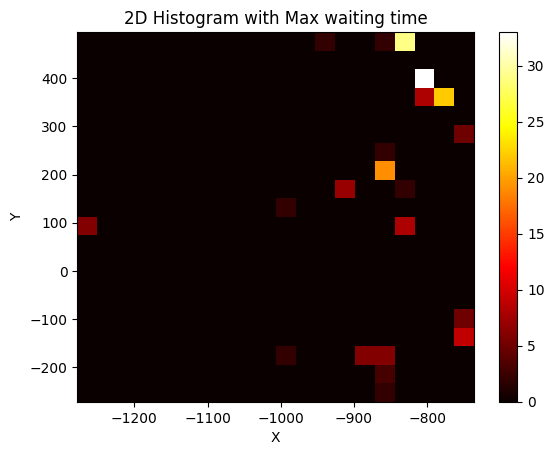

In [150]:
obj1.hiding_spot_identification()

In [116]:
temp = data[data['team']=='Team2']
temp[temp['side'] == 'T']['round_num'].unique()

array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [153]:
obj1.calc_common_strategy()

No, it is not a common stratergy as only 33.33333333333333% times which is less than 50% times


##Testing below this

```
# This is formatted as code
```



In [128]:
# checking at right entrance of tunnel(door to bombsiteb)
obj1.calc_common_strategy()

category
1
category
2
category
3
category
4
category
5
category
6
category
7
category
8
category
9
category
10
category
11
category
12
category
13
category
14
category
16
inside 1
round_num                                                                        16
tick                                                                         297801
side                                                                              T
team                                                                          Team2
hp                                                                               97
armor                                                                            98
is_alive                                                                       True
x                                                                             -1791
y                                                                               753
z                                                               

In [125]:
# checking at left entrance of tunnel
obj1.calc_common_strategy()

category
1
category
2
category
3
category
4
category
5
category
6
category
7
category
8
category
9
category
10
category
11
category
12
category
13
category
14
category
16
inside 1
round_num                                                                        16
tick                                                                         297576
side                                                                              T
team                                                                          Team2
hp                                                                               97
armor                                                                            98
is_alive                                                                       True
x                                                                             -1979
y                                                                               398
z                                                               

In [121]:
inner_lightblue_boundary = [(-1735, 250), (-2024, 398), (-2806, 742), (-2472, 1233), (-1565, 580)]
    # create a new boundary with an offset of 10 just near entrance
outer_lightblue_boundary = [(-1735 + 30, 250 - 30), (-2024, 398), (-2806, 742), (-2472, 1233), (-1565 + 30, 580 + 30)]
    
row = {'x':-2024,'y':398}
print(obj1.row_is_in_boundary(inner_lightblue_boundary,row))
print(obj1.row_is_in_boundary(outer_lightblue_boundary,row))

False
False


# Actual CLass according to the question

In [ ]:
# Wrong approach because i am dropping duplicates based on elapsed seconds and it resets to 0 at bomb plants so didnt consider that.

set_coor = []


grouped_data = data.groupby('round_num')

for category, group in grouped_data:
  
  # sorting by tick and then only choosing CT
  sorted_data_group = group.sort_values(by='tick')
  sorted_data_group_T = sorted_data_group[sorted_data_group['side']=='CT']


  # check if the Terrorist side is Team2 or not
  if sorted_data_group_T['team'].iloc[0] == 'Team1':
    continue
  
  # FIlter out data regarding only bombsite

  players_group_bombsite = sorted_data_group_T[sorted_data_group_T['area_name']=='BombsiteB']
  # print(players_group_bombsite)

  # Group now player wise and analyse individual player movement
  new_grouped_data = players_group_bombsite.groupby('player')


  for new_cat ,new_group in new_grouped_data:

    # new_group['WaitingTime'] = new_group.groupby(['x', 'y'])['seconds'].diff().fillna(pd.Timedelta(seconds=0))
    # print(new_group)

    # Now for each player we will check coordinate wise
    for acat, agr in new_group.groupby(['x','y']):
      
      # remove rows if he is dead
      agr = agr[agr['is_alive']==True] 
      
      
      if len(agr) > 2:
        first_row = agr.iloc[0]
        # last_row = agr.iloc[-1]

        prev = first_row['seconds']
        count_waiting = 0
        max_waiting = 0
        
        for index, row in agr.iterrows():

          
          if prev == row['seconds']:
            continue

          if prev == row['seconds']-1:
            prev = row['seconds']
            count_waiting +=1
          
          elif row['seconds'] == 0 and row['bomb_planted'] == True:
            count_waiting +=1
            prev = 0
          
          else:
            max_waiting = max(max_waiting, count_waiting)
            count_waiting = 0

        max_waiting = max(max_waiting, count_waiting)
       
        if max_waiting > 1:
          set_coor.append([acat[0],acat[1],max_waiting])
          continue

      
   
  
    

In [ ]:
set_coor
df_set = pd.DataFrame(set_coor, columns=['x', 'y','waiting'])

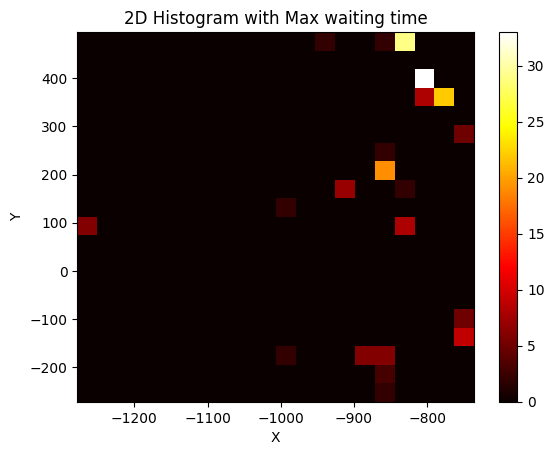

In [ ]:
import matplotlib.pyplot as plt

plt.hist2d(df_set['x'], df_set['y'], bins=20, cmap='hot', weights=df_set['waiting'])

# Add colorbar for reference
plt.colorbar()

# Set plot labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram with Max waiting time')

# Display the plot
plt.show()

In [49]:
obj1.calc_common_strategy()

TypeError: ignored